Creating custom class to load the dataset from the directories and create labels for train, test and validation dataset

In [1]:
import os
import pandas as pd
from torchvision.io import decode_image
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from PIL import Image
import torch.nn.functional as F

In [2]:
class ImageDatasetFromFolders(Dataset):
    def __init__(self, path, transform=ToTensor):
        self.path = path
        self.class_names = sorted(os.listdir(self.path))
        self.transform = transform
        complete_dataset = []
        for dir in os.listdir(self.path):
            for image in os.listdir(os.path.join(self.path, dir)):
                complete_dataset.append((dir, os.path.join(self.path, dir, image)))
        self.complete_dataset = complete_dataset
        
    def __len__(self):
        return len(self.complete_dataset)
    
    def get_example(self, idx):
        img_path = self.complete_dataset[idx][1]
        image = Image.open(img_path)
        label = self.complete_dataset[idx][0]
        label = self.class_names.index(label)
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def scale_image(self, img):
        max_pixel = np.max(np.array(img))
        img = img/max_pixel
        return img
    
    def __getitem__(self, idx):
        img_path = self.complete_dataset[idx][1]
        image = Image.open(img_path)
        label = self.complete_dataset[idx][0]
#         print(label)
        label = self.class_names.index(label)
#         print(label)
        if self.transform:
            image = self.transform(image)
#             image = self.scale_image(image)
        return image, label

In [3]:
'''
TODO: the ScaleImages class does not standardize all the channels, but only scales the pixel values 
within first channel.
'''

class ScaleImages():
    """Scale the image such that the min and max pixel values are 0 and 1.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self):
        pass
    def __call__(self, data):
        image, label = data[0], data[1]
        max_pixel = np.max(np.array(image))
        image = image/max_pixel
        return image, label    

In [3]:
base = os.getcwd()
train_dir = os.path.join(base,'Train')
test_dir = os.path.join(base,'Test')
val_dir = os.path.join(base,'Validation')

In [9]:
image_size = (256,256)
# transform = transforms.Compose([transforms.PILToTensor(), transforms.Resize(image_size), transforms.ToTensor()])
transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
train_data = ImageDatasetFromFolders(train_dir, transform=transform)
test_data = ImageDatasetFromFolders(test_dir, transform=transform)
val_data = ImageDatasetFromFolders(val_dir, transform=transform)
print((train_data[2][0]).dtype) #check the type of the data to make sure it is torch.float32
print(train_data[1000][0].shape) #check if the data has been scaled
print(test_data.__len__())
print(val_data.__len__())

torch.float32
torch.Size([3, 256, 256])
150
60


In [5]:
min_value = np.min(np.array(train_data[1000][0]))
max_value = np.max(np.array(train_data[1000][0]))
print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.07058824

Maximum pixel value in the Validation dataset 1.0


In [6]:
batch_size = 32
train_dl = DataLoader(train_data, batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size, shuffle=True)

In [20]:
a = next(iter(train_dl))[0][0]
a = a.unsqueeze(0)
print(a.shape)

torch.Size([1, 3, 256, 256])


In [7]:
labels_list = []

for i, (_, labels) in enumerate(val_dl):
    print(i)
    labels_list.append(labels)
labels = torch.cat(labels_list)
print(torch.unique(labels, return_counts=True))

0
1
(tensor([0, 1, 2]), tensor([20, 20, 20]))


TODO: make a helper function to visualize the images using the code below

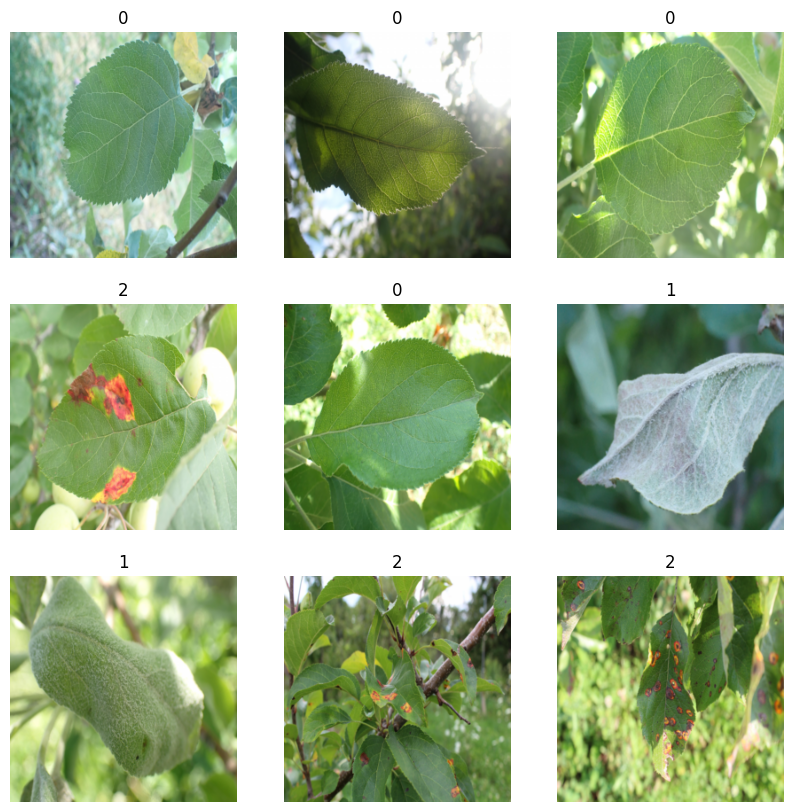

In [49]:
'''
permute reorders dimensions (no data mixing).
numpy.reshape reinterprets memory without moving anything — the data becomes scrambled and hence gray 
scaled images with 3x3 tiles.'''
fig = plt.figure(figsize=(10,10))
cols, rows = 3, 3
for i in range(9):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    img = img.permute(1, 2, 0).numpy()
#     print(img)
#     img = np.array(img).reshape((256,256,3))
    plt.subplot(3,3,i+1)
    plt.imshow((255*img).astype("uint8"))
    plt.title(label)
    plt.axis("off")
# print(255*img)
plt.show()
fig.clear()

Implementing the CNN architecture using pytorch

In [7]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):

        """
        Building blocks of convolutional neural network.

        Parameters:
           * in_channels: Number of channels in the input image (for grayscale images, 1)
           * num_classes: Number of classes to predict. In our problem, 10 (i.e digits from  0 to 9).
        """
        super(CNN, self).__init__()

        # 1st convolutional layer
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same')
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=None)
        # 2nd convolutional layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
        
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, 256, 256)   # your input size
            out = self._forward_features(dummy)
            flat_dim = out.numel()

        # Fully connected layer
        self.fc1 = nn.Linear(flat_dim, num_classes)
#         self.fc2 = nn.Linear(512,128)
#         self.fc3 = nn.Linear(128,num_classes)
        

    def _forward_features(self, x):
        """
        Define the forward pass of the neural network.

        Parameters:
           x: Input tensor.

        Returns:
           torch.Tensor
               The output tensor after passing through the network.
        """
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.dropout(x, p=0.2, training=self.training) 
        x = F.relu(self.conv3(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.relu(self.conv4(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)
        x = F.dropout(x, p=0.2, training=self.training)  
        return x
    
    def forward(self,x):
        x = self._forward_features(x)
#         x = x.reshape(x.shape[0], -1)  # Flatten the tensor
        x = torch.flatten(x,1)
#         print(x.shape)
        x = self.fc1(x)            # Apply fully connected layer
#         x = F.dropout(x, p=0.4, training=self.training) 
#         x = self.fc2(x)
#         x = self.fc3(x)
        return x

In [8]:
model = CNN(in_channels=3, num_classes=3)
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=131072, out_features=3, bias=True)
)


In [9]:
from torchinfo import summary
summary(model, (32,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 3]                   --
├─Conv2d: 1-1                            [32, 16, 256, 256]        448
├─Conv2d: 1-2                            [32, 16, 256, 256]        2,320
├─MaxPool2d: 1-3                         [32, 16, 128, 128]        --
├─Conv2d: 1-4                            [32, 32, 128, 128]        4,640
├─Conv2d: 1-5                            [32, 32, 128, 128]        9,248
├─MaxPool2d: 1-6                         [32, 32, 64, 64]          --
├─Linear: 1-7                            [32, 3]                   393,219
Total params: 409,875
Trainable params: 409,875
Non-trainable params: 0
Total mult-adds (G): 13.10
Input size (MB): 25.17
Forward/backward pass size (MB): 805.31
Params size (MB): 1.64
Estimated Total Size (MB): 832.11

#### making an helper function to see if I can replicate the model_summary thing so that I can use if for later projects

In [12]:
def forward_with_shape_printing(model, x):
    print(f"Input shape: \t\t{x.shape}") # Using tabs for alignment
    
    x = model.conv1(x)  # Apply first convolution
    print(f"After conv_block1: \t{x.shape}")
    x = model.pool(x)   # Apply max pooling
    print(f"After max pool: \t{x.shape}")
    x = model.conv2(x)  # Apply second convolution
    print(f"After conv_block1: \t{x.shape}")
    x = model.pool(x)   # Apply max pooling
    print(f"After max pool: \t{x.shape}")
    x = model.conv3(x)  # Apply third convolution 
    print(f"After conv_block1: \t{x.shape}")
    x = model.pool(x)   # Apply max pooling
    print(f"After max pool: \t{x.shape}")
    x = model.conv4(x)  # Apply fourth convolution
    print(f"After conv_block1: \t{x.shape}")
    x = model.pool(x)   # Apply max pooling
    print(f"After max pool: \t{x.shape}")

    # Flatten the features
    x = torch.flatten(x,1)
    print(f"After flatten: \t\t{x.shape}")

    # Pass through fully connected layers (only showing final output shape)
#     x = F.relu(model.fc1(x))
#     x = model.dropout1(x)
#     x = F.relu(model.fc2(x))
#     x = model.dropout2(x)
    logits = model.fc1(x)
    print(f"Output shape (logits): \t{logits.shape}") # Corrected variable name

    return logits

In [33]:
dummy_input = torch.randn(32, 3, 256, 256)
print("Running shape verification pass:")
_ = forward_with_shape_printing(model, dummy_input)

Running shape verification pass:
Input shape: 		torch.Size([32, 3, 256, 256])
After conv_block1: 	torch.Size([32, 16, 256, 256])
After max pool: 	torch.Size([32, 16, 128, 128])
After conv_block1: 	torch.Size([32, 16, 128, 128])
After max pool: 	torch.Size([32, 16, 64, 64])
After conv_block1: 	torch.Size([32, 32, 64, 64])
After max pool: 	torch.Size([32, 32, 32, 32])
After conv_block1: 	torch.Size([32, 32, 32, 32])
After max pool: 	torch.Size([32, 32, 16, 16])
After flatten: 		torch.Size([32, 8192])
Output shape (logits): 	torch.Size([32, 3])


In [22]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
# criterion = torch.nn.CrossEntropyLoss()

In [21]:
#overfitting the model to see if the train accuracy reaches 1
# model.train()
# images, labels = next(iter(val_dl))
# # images, labels = images.to(device), labels.to(device)
# print(len(images))

# for i in range(100):
#     optimizer.zero_grad()
#     out = model(images)
#     loss = criterion(out, labels)
#     loss.backward()
#     optimizer.step()
# #     print(out)

#     acc = (out.argmax(1) == labels).float().mean()
#     print(i, loss.item(), acc.item())

In [14]:
from tqdm import tqdm
def train(image, target):
    model.train()
    optimizer.zero_grad()
    out = model(image)
    loss = criterion(out, target)
    loss.backward()
    optimizer.step()
    return loss

def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

def train_model(model, train_loader, val_loader, criterion, optimizer,model_name, num_epochs=10):
    print(f'Starting training the {model_name}.pt.......')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)
    
    train_accuracy = []
    train_loss = []
    validation_accuracy = []
    validation_loss = []
    num_epochs = num_epochs
    for epoch in range(1, num_epochs+1):
        print(f"Epoch [{epoch}/{num_epochs}]")
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for batch_index, (images, labels) in enumerate(train_loader):
#             images = images/255
#             images = images.float()
            images = images.to(device)
            labels = labels.to(device)
            model.train()
            optimizer.zero_grad()
            out = model(images)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
#             print(out)

            # Track training loss and accuracy
            running_loss += loss.item() * images.size(0)  # loss.item() is the avg loss per batch
#             _, predicted = torch.max(out.data, 1)
#             total_train += labels.size(0)
            acc_train_batch = (out.argmax(1) == labels).float().mean()
#             print(acc_train_batch.item())
            correct_train += acc_train_batch.item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
#         print(f'{correct_train=}')
#         print(f'{len(train_loader)}')
        epoch_train_acc = correct_train / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_acc)

        model.eval()  # Set model to evaluation mode (disables dropout, uses running stats for batch norm)
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch, (images, labels) in enumerate(val_loader):
#                 images = images/255
#                 images = images.float()
                images = images.to(device)
                labels = labels.to(device)
                out = model(images)
                loss = criterion(out, labels)

                val_loss += loss.item() * images.size(0)
#                 _, predicted = torch.max(out.data, 1)
#                 total_val += labels.size(0)
                acc_val_batch = (out.argmax(1) == labels).float().mean()
#                 print(acc_val_batch.item())
                correct_val += acc_val_batch.item()

            # Calculate validation statistics for the epoch
        epoch_val_loss = val_loss / len(val_loader.dataset)
#         print(f'{correct_val=}')
#         print(f'{len(val_loader)}')
        epoch_val_acc = correct_val/ len(val_loader)              
        validation_loss.append(epoch_val_loss)                    
        validation_accuracy.append(epoch_val_acc) 


        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"  Validation Loss: {epoch_val_loss:.4f}, Validation Acc: {epoch_val_acc:.4f}")
        print('-'*30)
        
    print("Finished Training.....")
    print('Saving model and the training accuracies....')
    torch.save(model, f'{model_name}.pt')
    training_details = {'train_losses': train_loss, 'train_accuracies': train_accuracy, 
                        'val_losses': validation_loss, 'val_accuracies': validation_accuracy}
    torch.save(training_details, f'train_val_accuracy_data.pt')
    return training_details
        

In [15]:
model_new = CNN(in_channels=3, num_classes=3)
print(model_new)
optimizer = torch.optim.Adam(model_new.parameters(), lr=0.0001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
train_model(model_new, val_dl, val_dl, criterion, optimizer,'recognize_disease_test')

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=8192, out_features=3, bias=True)
)
Starting training the recognize_disease_test.pt.......
Using device: cpu
Epoch [1/10]
  Train Loss: 1.0998, Train Acc: 0.3862
  Validation Loss: 1.0986, Validation Acc: 0.3527
------------------------------
Epoch [2/10]
  Train Loss: 1.1013, Train Acc: 0.2656
  Validation Loss: 1.0983, Validation Acc: 0.3415
------------------------------
Epoch [3/10]
  Train Loss: 1.0974, Train Acc: 0.3772
  Validation Loss: 1.0980, Validation Acc: 0.3527
------------------------------
Epoch [4/10]
  Train Loss: 1.0954, Train Acc: 0.3951
  Validation Loss: 1

{'train_losses': [1.0998385270436606,
  1.1012592713038127,
  1.0973558266957602,
  1.0953582127888997,
  1.0980244874954224,
  1.096385391553243,
  1.0966318686803183,
  1.0947625001271566,
  1.0974667469660442,
  1.097091269493103],
 'train_accuracies': [0.3861607164144516,
  0.265625,
  0.3772321343421936,
  0.3950892835855484,
  0.3950892835855484,
  0.4040178507566452,
  0.46875,
  0.4196428507566452,
  0.3325892835855484,
  0.3861607164144516],
 'val_losses': [1.098558251063029,
  1.0982865333557128,
  1.098006216684977,
  1.0978118340174357,
  1.0975779612859091,
  1.0973403215408326,
  1.0971184651056924,
  1.0968302885691326,
  1.0965481519699096,
  1.096229855219523],
 'val_accuracies': [0.3526785671710968,
  0.3415178507566452,
  0.3526785671710968,
  0.3303571492433548,
  0.3191964328289032,
  0.3816964328289032,
  0.3370535671710968,
  0.328125,
  0.3236607164144516,
  0.3816964328289032]}

### Lets see the performance of the model with few layers: especially the following structure

In [8]:
model = torch.load('recognize_disease_28_12.pt', weights_only=False, map_location=torch.device('cpu'))
training_details = torch.load('train_val_accuracy_data.pt')

In [9]:
from torchinfo import summary
print('Model details\n')
print(model)
print('\nSummary of the architecture\n')
print(summary(model, (32,3,256,256)))

Model details

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=8192, out_features=3, bias=True)
)

Summary of the architecture

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 3]                   --
├─Conv2d: 1-1                            [32, 16, 256, 256]        448
├─MaxPool2d: 1-2                         [32, 16, 128, 128]        --
├─Conv2d: 1-3                            [32, 16, 128, 128]        2,320
├─MaxPool2d: 1-4                         [32, 16, 64, 64]          --
├─Conv2d: 1-5                            [32, 32, 64, 64]          4,640
├

In [10]:
# print(training_details)
train_losses = training_details['train_losses']
val_losses = training_details['val_losses']
train_accuracies = training_details['train_accuracies']
val_accuracies = training_details['val_accuracies']
print(train_accuracies)

[0.413839286281949, 0.510714285430454, 0.6479166675181616, 0.7011904759066445, 0.7415178574266887, 0.7578869050457364, 0.7625000008514949, 0.7672619053295681, 0.7648809523809523, 0.7699404770419711, 0.797470238946733, 0.7973214288552603, 0.7927083330495017, 0.8002976193314507, 0.8077380955219269, 0.8188988098076412, 0.813541666382835, 0.8202380949542636, 0.8242559532324473, 0.8193452386629014, 0.8285714288552603, 0.8413690484705425, 0.8331845246610188, 0.850297619899114, 0.8422619047619048, 0.8452380952380952, 0.8412202383790698, 0.8348214285714286, 0.8488095246610188, 0.8534226190476191, 0.8531250002838316, 0.8425595235256922, 0.8546130955219269, 0.8541666666666666, 0.862053571712403]


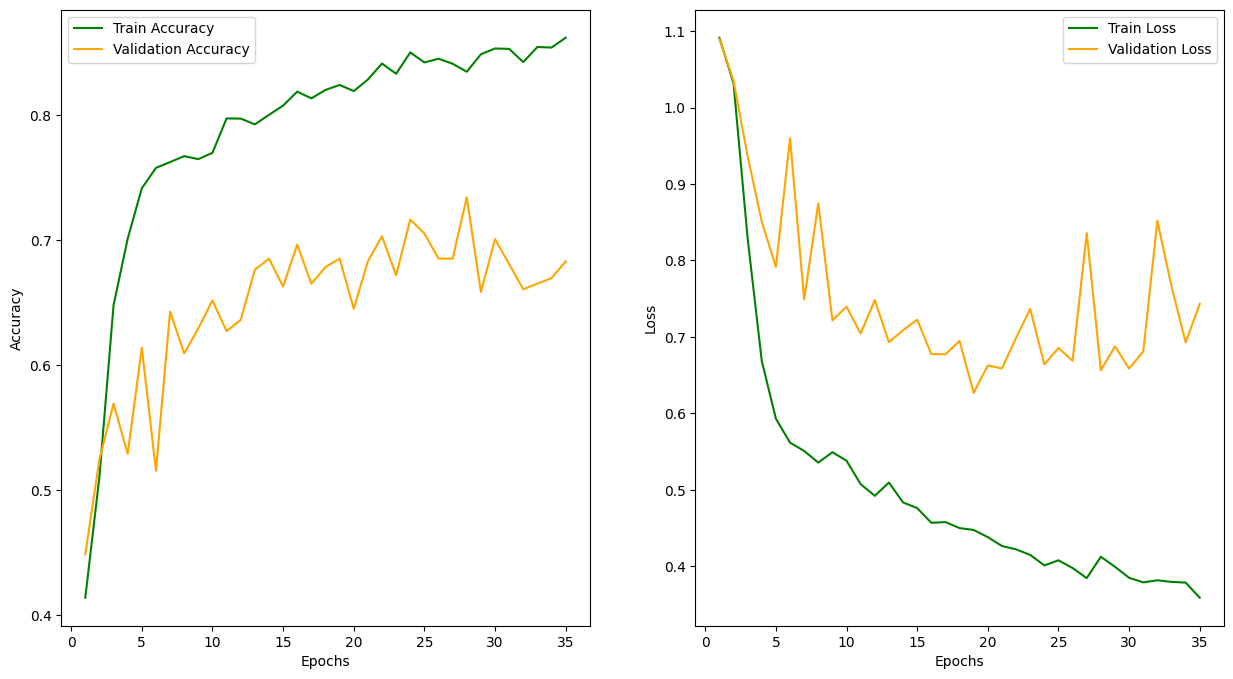

In [11]:
num_epochs = range(1,len(train_accuracies)+1)
fig, axs = plt.subplots(1,2)
# print(axs)
axs[0].plot(num_epochs, train_accuracies,color='g', label='Train Accuracy')
axs[0].plot(num_epochs, val_accuracies, color='orange', label='Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[1].plot(num_epochs, train_losses,color='g', label='Train Loss')
axs[1].plot(num_epochs, val_losses, color='orange', label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
fig.set_size_inches((15,8))
plt.show()


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
model.eval()  # Set model to evaluation mode (disables dropout, uses running stats for batch norm)
val_loss = 0.0
correct_val = 0
total_val = 0

with torch.no_grad():
    for batch, (images, labels) in enumerate(val_dl): 
        out = model(images)
        loss = criterion(out, labels)

        val_loss += loss.item() * images.size(0)
        acc_val_batch = (out.argmax(1) == labels).float().mean()
#                 print(acc_val_batch.item())
        correct_val += acc_val_batch.item()

            # Calculate validation statistics for the epoch
epoch_val_loss = val_loss / len(val_dl.dataset)
#         print(f'{correct_val=}')
#         print(f'{len(val_loader)}')
epoch_val_acc = correct_val/ len(val_dl)  

In [13]:
print('Accuracy and loss on Validation set (not so meaningful as it was trained on that)')
print('Accuracy: ', epoch_val_acc)
print('Loss:', epoch_val_loss)

Accuracy and loss on Validation set (not so meaningful as it was trained on that)
Accuracy:  0.6785714328289032
Loss: 0.7431811730066935


In [14]:
model.eval()  # Set model to evaluation mode (disables dropout, uses running stats for batch norm)
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for batch, (images, labels) in enumerate(test_dl): 
        out = model(images)
        loss = criterion(out, labels)

        test_loss += loss.item() * images.size(0)
        acc_test_batch = (out.argmax(1) == labels).float().mean()
#                 print(acc_val_batch.item())
        correct_test += acc_test_batch.item()

            # Calculate validation statistics for the epoch
epoch_test_loss = test_loss / len(test_dl.dataset)
#         print(f'{correct_val=}')
#         print(f'{len(val_loader)}')
epoch_test_acc = correct_test/ len(test_dl)  

In [15]:
print('Accuracy and loss on Test set')
print('Accuracy: ', epoch_test_acc)
print('Loss:', epoch_test_loss)

Accuracy and loss on Test set
Accuracy:  0.6301136374473572
Loss: 0.8664347179730734


### Lets see the performance of the model with more complex layers: especially the following structure

Model details

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=65536, out_features=3, bias=True)
)

Summary of the architecture

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 3]                   --
├─Conv2d: 1-1                            [32, 64, 256, 256]        1,792
├─MaxPool2d: 1-2                         [32, 64, 128, 128]        --
├─Conv2d: 1-3                            [32, 128, 128, 128]       73,856
├─MaxPool2d: 1-4                         [32, 128, 64, 64]         --
├─Conv2d: 1-5                            [32, 256, 64, 64]       

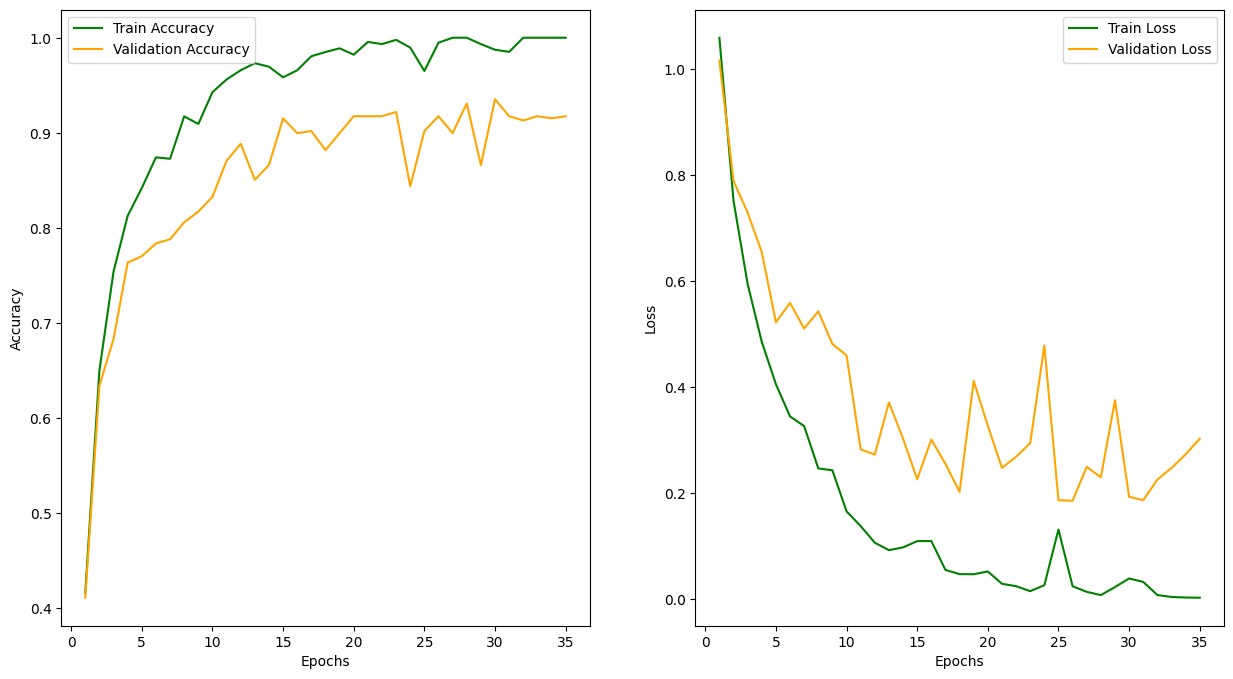

Accuracy and loss on Validation set (not so meaningful as it was trained on that)
Accuracy:  0.9196428656578064
Loss: 0.30226027220487595
Accuracy and loss on Test set
Accuracy:  0.9039772748947144
Loss: 0.45656168937683106


In [8]:
model = torch.load('recognize_disease_29_12_more_layers.pt', weights_only=False, map_location=torch.device('cpu'))
training_details = torch.load('train_val_accuracy_data_more_layers.pt')

from torchinfo import summary
print('Model details\n')
print(model)
print('\nSummary of the architecture\n')
print(summary(model, (32,3,256,256)))

# print(training_details)
train_losses = training_details['train_losses']
val_losses = training_details['val_losses']
train_accuracies = training_details['train_accuracies']
val_accuracies = training_details['val_accuracies']

num_epochs = range(1,len(train_accuracies)+1)
fig, axs = plt.subplots(1,2)
# print(axs)
axs[0].plot(num_epochs, train_accuracies,color='g', label='Train Accuracy')
axs[0].plot(num_epochs, val_accuracies, color='orange', label='Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[1].plot(num_epochs, train_losses,color='g', label='Train Loss')
axs[1].plot(num_epochs, val_losses, color='orange', label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
fig.set_size_inches((15,8))
plt.show()


optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
model.eval()  # Set model to evaluation mode (disables dropout, uses running stats for batch norm)
val_loss = 0.0
correct_val = 0
total_val = 0

with torch.no_grad():
    for batch, (images, labels) in enumerate(val_dl): 
        out = model(images)
        loss = criterion(out, labels)

        val_loss += loss.item() * images.size(0)
        acc_val_batch = (out.argmax(1) == labels).float().mean()
#                 print(acc_val_batch.item())
        correct_val += acc_val_batch.item()

            # Calculate validation statistics for the epoch
epoch_val_loss = val_loss / len(val_dl.dataset)
#         print(f'{correct_val=}')
#         print(f'{len(val_loader)}')
epoch_val_acc = correct_val/ len(val_dl)  

print('Accuracy and loss on Validation set (not so meaningful as it was trained on that)')
print('Accuracy: ', epoch_val_acc)
print('Loss:', epoch_val_loss)

# model.eval()  # Set model to evaluation mode (disables dropout, uses running stats for batch norm)
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for batch, (images, labels) in enumerate(test_dl): 
        out = model(images)
        loss = criterion(out, labels)

        test_loss += loss.item() * images.size(0)
        acc_test_batch = (out.argmax(1) == labels).float().mean()
#                 print(acc_val_batch.item())
        correct_test += acc_test_batch.item()

            # Calculate validation statistics for the epoch
epoch_test_loss = test_loss / len(test_dl.dataset)
#         print(f'{correct_val=}')
#         print(f'{len(val_loader)}')
epoch_test_acc = correct_test/ len(test_dl)  

print('Accuracy and loss on Test set')
print('Accuracy: ', epoch_test_acc)
print('Loss:', epoch_test_loss)

In [66]:
import numpy as np

def softmax(logits):
    logits = np.array(logits)
    # Step 1: Exponentiate the logits to scale them
    exp_values = np.exp(logits - np.max(logits))  # Subtracting max for numerical stability
    # Step 2: Normalize the exponentials by dividing with their sum
    probabilities = exp_values / np.sum(exp_values)
    return probabilities

# # Example usage
# logits = np.array([3.4, -11.34, 0.8137])
# probabilities = softmax(logits)

# print("Logits:", logits)
# print("Probabilities:", probabilities)

def Prediction(model,img):
    img_array = img.unsqueeze(0)     # create a batch, as the input is expected as a batch
    
    model.eval()
    with torch.no_grad():
        out = model(img_array)
        predicted_class = out.argmax(1)
        probabilities = softmax(out)
    
    return predicted_class[0], probabilities[0][predicted_class[0]], out

In [63]:
img_array = next(iter(test_dl))[0][2]
print(Prediction(model,img_array))

(tensor(0), 0.9994017, tensor([[ 4.4364, -3.1247, -5.0178]]))


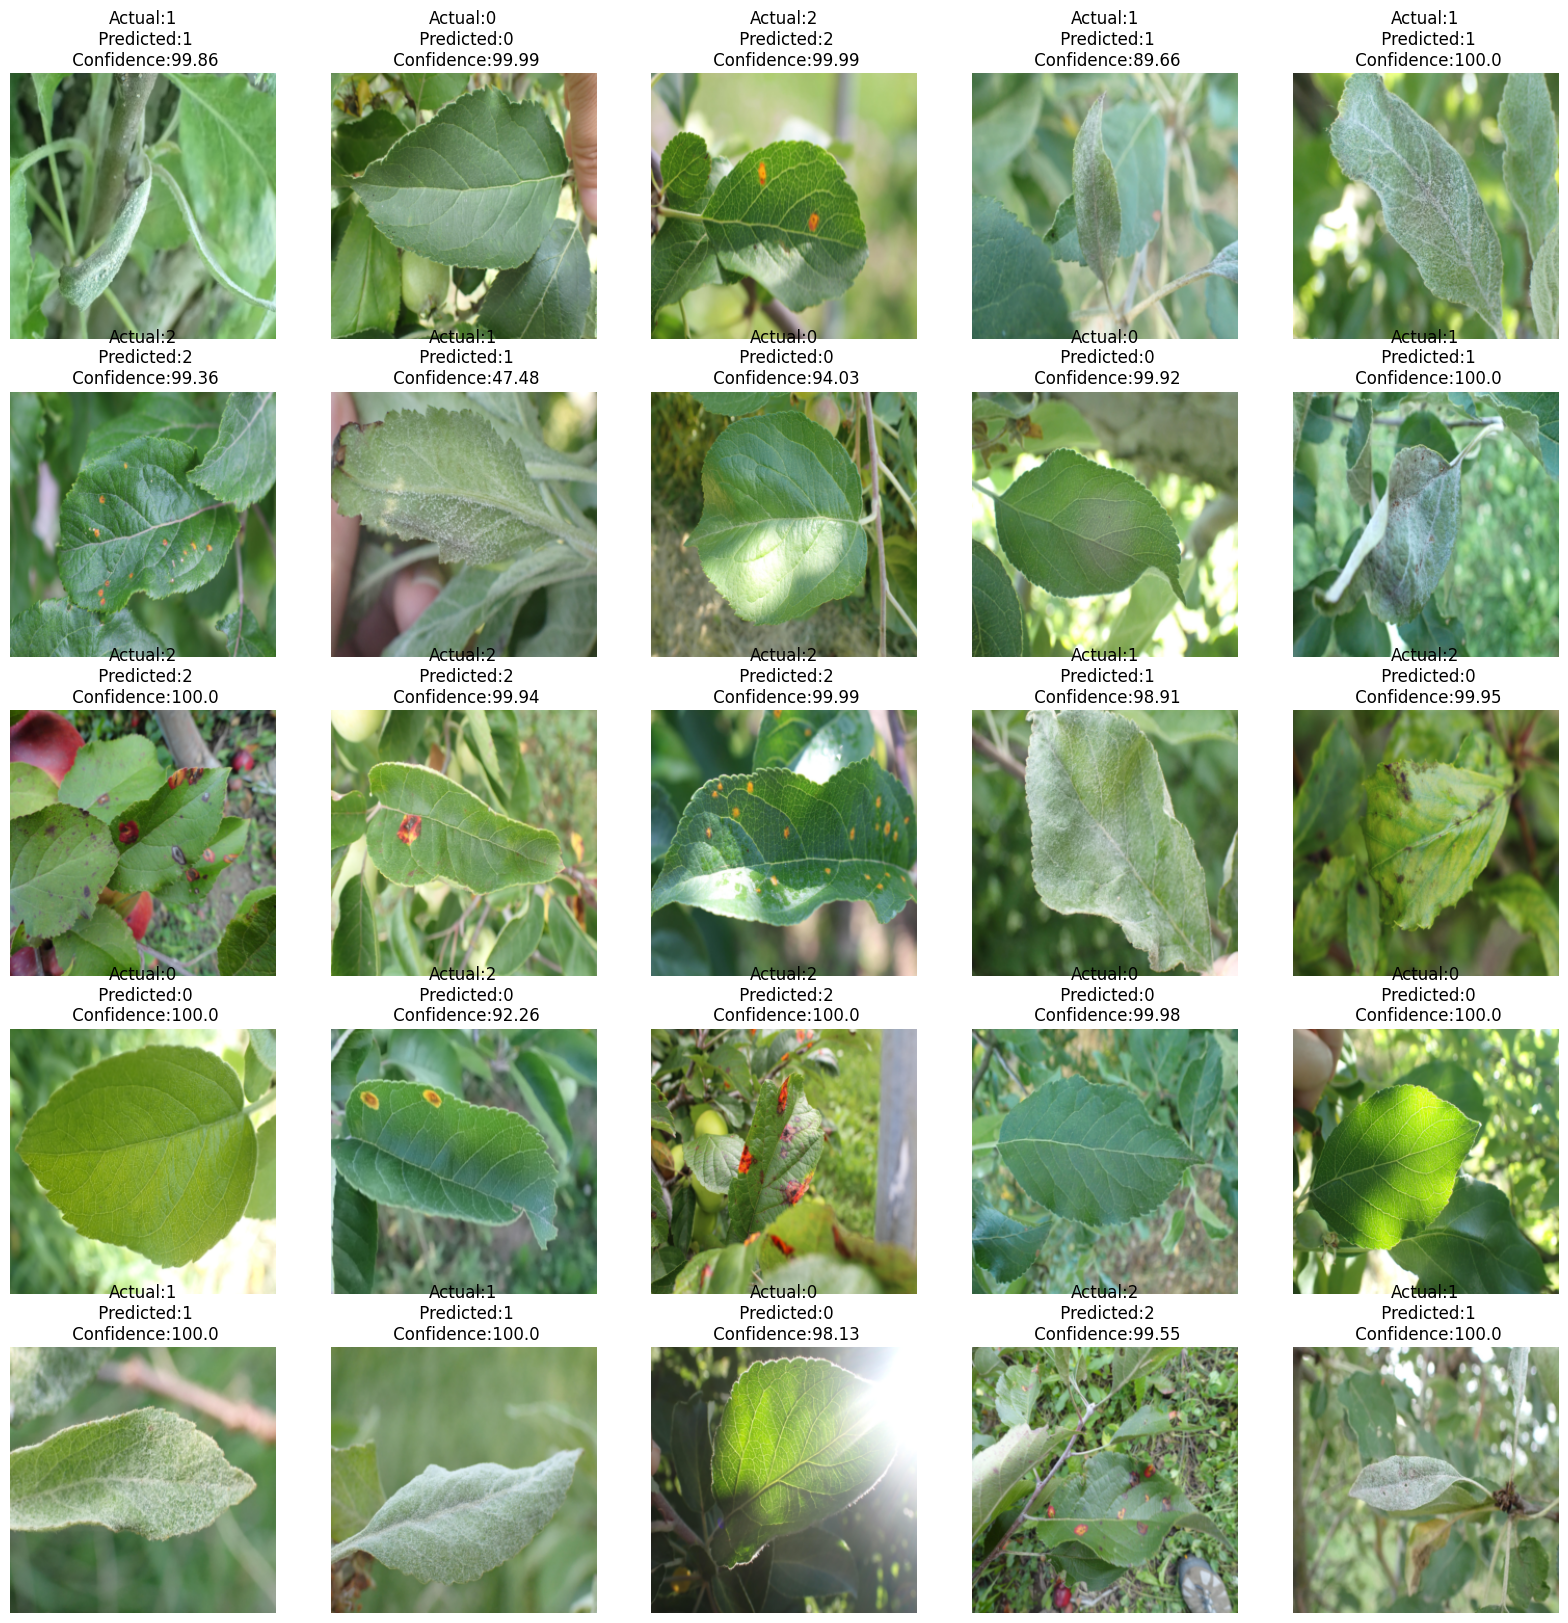

In [65]:
fig = plt.figure(figsize=(20,20))
cols, rows = 5, 5
for i in range(25):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    predicted_class, prob, _ = Prediction(model, img)
    img = img.permute(1, 2, 0).numpy()
#     print(img)
#     img = np.array(img).reshape((256,256,3))
    plt.subplot(5,5,i+1)
    plt.imshow((255*img).astype("uint8"))
    plt.title(f"Actual:{label}\n Predicted:{predicted_class}\n Confidence:{np.round(prob*100,2)}")
    plt.axis("off")
# print(255*img)
plt.show()
fig.clear()